In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split 

c:\Users\PLour\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Bibliotecas necessárias
# Manipulação de dados
import pandas as pd
# Redes Neurais
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
# Plot
import matplotlib.pyplot as plt
%matplotlib inline
# Avaliação
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import time
import os

## Prepare Data

In [4]:
suicide_db = pd.read_csv('data/final.csv')

y = suicide_db['suicatt']
X = suicide_db[suicide_db.columns[[1,2,3,4,5,7,8,9,10,11,14,15,17,30,31]]].drop(columns='ideation')


In [5]:
def normalize(x):
  return (x - 13) / (17 - 13)

X['age'] = X['age'].apply(normalize)

### MLP prevendo tentativa:

In [6]:
seed = 257
rng = np.random.default_rng(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
total = list(range(y.shape[0]))
train_id = rng.choice(total, size = int(0.8*len(total)), replace = False)
val_test = [x for x in total if x not in train_id]
val_id = rng.choice(val_test, size = int(len(val_test)/2), replace = False)
test_id = [x for x in val_test if x not in val_id]

In [8]:
len(train_id), len(val_id), len(test_id)

(1008, 126, 127)

In [9]:
def get_batch(idx, X, y, batch_size):
    batch = rng.choice(idx, size = batch_size, replace = False)
    x = torch.stack([torch.tensor(X.iloc[i]) for i in batch])
    y_out = torch.stack([torch.tensor(y.iloc[i]) for i in batch])
    return batch, x.to(device = device, dtype=torch.float), y_out.to(device = device, dtype=torch.float)

In [10]:
batch_size = 64
input_dim = 14
output_dim = 1
epochs = 600

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_layer = nn.Linear(input_dim, 10)
        self.hidden_layer = nn.Linear(10, 5)
        self.output_layer = nn.Linear(5, output_dim)

    def forward(self, x):
        # x = [batch size, input_dim]
        h_1 = F.relu(self.input_layer(x))
        # h_1 = [batch size, 20]
        h_2 = F.relu(self.hidden_layer(h_1))
        # h_2 = [batch size, 10]
        y_pred = self.output_layer(h_2)
        # y_pred = [batch size, 1]
        return torch.sigmoid(y_pred)

In [12]:
model = MLP(input_dim, output_dim)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [13]:
def train(model: nn.Module):
    model.train()
    total_loss = 0.
    start_time = time.time()

    n_batches = len(train_id) // batch_size
    aux_train = train_id
    for b in range(n_batches):
        batch, x, y_out = get_batch(aux_train, X, y, batch_size)
        aux_train = [x for x in aux_train if x not in batch]

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(torch.squeeze(y_pred), y_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / n_batches

In [14]:
def evaluate(model: nn.Module, data_id):
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        n_batches = len(data_id) // batch_size
        aux_data = data_id
        for b in range(n_batches):
            batch, x, y_out = get_batch(aux_data, X, y, batch_size)
            aux_data = [x for x in aux_data if x not in batch]

            y_pred = model(x)
            total_loss += criterion(torch.squeeze(y_pred), y_out).item()
    return total_loss / n_batches

In [15]:
best_val_loss = float('inf')
best_model_params_path = os.path.join('', "model.pt")

count = 0
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    total_train_loss = train(model)
    with open("train_model.txt", "a") as f:
        f.write(str(total_train_loss)+',')
        f.close()

    total_val_loss = evaluate(model, val_id)
    with open("val_model.txt", "a") as f:
        f.write(str(total_val_loss)+',')
        f.close()

    elapsed = time.time() - epoch_start_time
    print('-' * 72)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'train loss {total_train_loss:5.2f} | valid loss {total_val_loss:5.2f}')
    print('-' * 72)

    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_params_path)
    elif count > 30:
        print('EARLY STOPPING')
        break
    else:
        count += 1

model.load_state_dict(torch.load(best_model_params_path))

------------------------------------------------------------------------
| end of epoch   1 | time:  0.75s | train loss  0.60 | valid loss  0.59
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   2 | time:  0.97s | train loss  0.58 | valid loss  0.56
------------------------------------------------------------------------


------------------------------------------------------------------------
| end of epoch   3 | time:  0.91s | train loss  0.56 | valid loss  0.56
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   4 | time:  0.65s | train loss  0.55 | valid loss  0.53
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   5 | time:  0.53s | train loss  0.53 | valid loss  0.51
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   6 | time:  0.67s | train loss  0.51 | valid loss  0.52
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   7 | time:  0.44s | train loss  0.49 | 

<All keys matched successfully>

In [16]:
total_test_loss = evaluate(model, test_id)
total_test_loss

0.06895525008440018

In [17]:
preds = []
with torch.no_grad():
  for i in test_id:
    batch, x, y_out = get_batch(i, X, y, 1)
    y_pred = model(x)
    print(y_pred)
    preds.append(torch.squeeze(y_pred).detach().numpy())

tensor([[0.0349]])
tensor([[0.0349]])
tensor([[0.0418]])
tensor([[0.0135]])
tensor([[0.0239]])
tensor([[0.2315]])
tensor([[0.1974]])
tensor([[0.0407]])
tensor([[0.0418]])
tensor([[0.0331]])
tensor([[0.1165]])
tensor([[0.1165]])
tensor([[0.0092]])
tensor([[0.0458]])
tensor([[0.0097]])
tensor([[0.0411]])
tensor([[0.0228]])
tensor([[0.0189]])
tensor([[0.0631]])
tensor([[0.0239]])
tensor([[0.0069]])
tensor([[0.0631]])
tensor([[0.0458]])
tensor([[0.0288]])


tensor([[0.0458]])
tensor([[0.1278]])
tensor([[0.0615]])
tensor([[0.0189]])
tensor([[0.0171]])
tensor([[0.0411]])
tensor([[0.2260]])
tensor([[0.1080]])
tensor([[0.0069]])
tensor([[0.0171]])
tensor([[0.0135]])
tensor([[0.0097]])
tensor([[0.0069]])
tensor([[0.0069]])
tensor([[0.0172]])
tensor([[0.1913]])
tensor([[0.0171]])
tensor([[0.0164]])
tensor([[0.0835]])
tensor([[0.0135]])
tensor([[0.0050]])
tensor([[0.0132]])
tensor([[0.0050]])
tensor([[0.0608]])
tensor([[0.0698]])
tensor([[0.0458]])
tensor([[0.2260]])
tensor([[0.0097]])
tensor([[0.0944]])
tensor([[0.0331]])
tensor([[0.0239]])
tensor([[0.0135]])
tensor([[0.1270]])
tensor([[0.0328]])
tensor([[0.0631]])
tensor([[0.0332]])
tensor([[0.0135]])
tensor([[0.0458]])
tensor([[0.0107]])
tensor([[0.0189]])
tensor([[0.1456]])
tensor([[0.2936]])
tensor([[0.0135]])
tensor([[0.1972]])
tensor([[0.0036]])
tensor([[0.0375]])
tensor([[0.0135]])
tensor([[0.0149]])
tensor([[0.0171]])
tensor([[0.0239]])
tensor([[0.1302]])
tensor([[0.0458]])
tensor([[0.0

In [18]:
threshold = 0.5
y_pred = []
for i in preds:
  if i > threshold:
    y_pred.append(1)
  else:
    y_pred.append(0)

y_true = []
for i in test_id:
  y_true.append(int(y.iloc[i]))

In [19]:
precision_recall_fscore_support(y_true, y_pred, average='macro'), precision_recall_fscore_support(y_true, y_pred, average='micro')

c:\Users\PLour\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


((0.484251968503937, 0.5, 0.49199999999999994, None),
 (0.968503937007874, 0.968503937007874, 0.968503937007874, None))

In [20]:
f = open("train_model.txt", "r")
train_loss = f.read().split(',')
train_loss = [float(i) for i in train_loss[:-1]]
f.close()
f = open("val_model.txt", "r")
val_loss = f.read().split(',')
val_loss = [float(i) for i in val_loss[:-1]]
f.close()

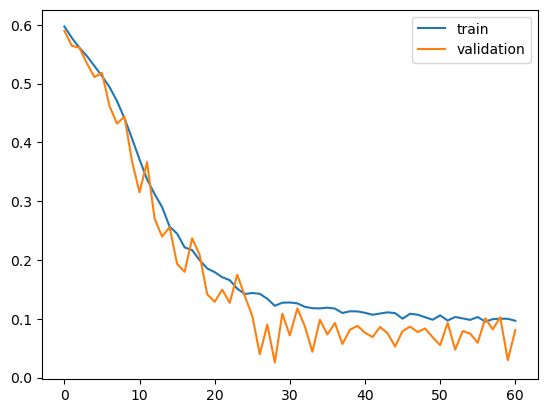

In [21]:
plt.plot(train_loss, label = "train")
plt.plot(val_loss, label = "validation")
plt.legend()
plt.show()

In [22]:
preds_suicatt = []
with torch.no_grad():
  for i in range(X.shape[0]):
    x = torch.stack([torch.tensor(X.iloc[a]) for a in [i]])
    y_pred = model(x.to(device = device, dtype=torch.float))
    preds_suicatt.append(torch.squeeze(y_pred).detach().numpy())

In [23]:
preds_suicatt = np.array(preds_suicatt)
preds_suicatt

array([0.02385808, 0.04176897, 0.0227623 , ..., 0.02385808, 0.02385808,
       0.00693277], dtype=float32)

In [24]:
errors = y - preds_suicatt
errors

0      -0.023858
1      -0.041769
2      -0.022762
3      -0.034931
4       0.917204
          ...   
1256   -0.063052
1257   -0.020374
1258   -0.023858
1259   -0.023858
1260   -0.006933
Name: suicatt, Length: 1261, dtype: float64

In [25]:
errors.to_csv('result/errors_pred_suicatt.csv', index=False)

### Predict for ideation

In [26]:
y = suicide_db['ideation']
X = suicide_db[suicide_db.columns[[1,2,3,4,5,7,8,9,10,13,14,15,17,30,31]]].drop(columns='suicatt')

In [27]:
X['age'] = X['age'].apply(normalize)

In [28]:
seed = 257
rng = np.random.default_rng(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
total = list(range(y.shape[0]))
train_id = rng.choice(total, size = int(0.8*len(total)), replace = False)
val_test = [x for x in total if x not in train_id]
val_id = rng.choice(val_test, size = int(len(val_test)/2), replace = False)
test_id = [x for x in val_test if x not in val_id]

In [30]:
len(train_id), len(val_id), len(test_id)

(1008, 126, 127)

In [31]:
def get_batch(idx, X, y, batch_size):
    batch = rng.choice(idx, size = batch_size, replace = False)
    x = torch.stack([torch.tensor(X.iloc[i]) for i in batch])
    y_out = torch.stack([torch.tensor(y.iloc[i]) for i in batch])
    return batch, x.to(device = device, dtype=torch.float), y_out.to(device = device, dtype=torch.float)

In [32]:
batch_size = 64
input_dim = 14
output_dim = 1
epochs = 600

In [33]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_layer = nn.Linear(input_dim, 10)
        self.hidden_layer = nn.Linear(10, 5)
        self.output_layer = nn.Linear(5, output_dim)

    def forward(self, x):
        # x = [batch size, input_dim]
        h_1 = F.relu(self.input_layer(x))
        # h_1 = [batch size, 20]
        h_2 = F.relu(self.hidden_layer(h_1))
        # h_2 = [batch size, 10]
        y_pred = self.output_layer(h_2)
        # y_pred = [batch size, 1]
        return torch.sigmoid(y_pred)

In [34]:
model = MLP(input_dim, output_dim)
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [35]:
def train(model: nn.Module):
    model.train()
    total_loss = 0.
    start_time = time.time()

    n_batches = len(train_id) // batch_size
    aux_train = train_id
    for b in range(n_batches):
        batch, x, y_out = get_batch(aux_train, X, y, batch_size)
        aux_train = [x for x in aux_train if x not in batch]

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(torch.squeeze(y_pred), y_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / n_batches

In [36]:
def evaluate(model: nn.Module, data_id):
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        n_batches = len(data_id) // batch_size
        aux_data = data_id
        for b in range(n_batches):
            batch, x, y_out = get_batch(aux_data, X, y, batch_size)
            aux_data = [x for x in aux_data if x not in batch]

            y_pred = model(x)
            total_loss += criterion(torch.squeeze(y_pred), y_out).item()
    return total_loss / n_batches

In [37]:
best_val_loss = float('inf')
best_model_params_path = os.path.join('', "model.pt")

count = 0
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    total_train_loss = train(model)
    with open("train_model_id.txt", "a") as f:
        f.write(str(total_train_loss)+',')
        f.close()

    total_val_loss = evaluate(model, val_id)
    with open("val_model_id.txt", "a") as f:
        f.write(str(total_val_loss)+',')
        f.close()

    elapsed = time.time() - epoch_start_time
    print('-' * 72)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'train loss {total_train_loss:5.2f} | valid loss {total_val_loss:5.2f}')
    print('-' * 72)

    if total_val_loss < best_val_loss:
        count = 0
        best_val_loss = total_val_loss
        torch.save(model.state_dict(), best_model_params_path)
    elif count > 30:
        print('EARLY STOPPING')
        break
    elif np.round(total_train_loss, 2) == 0:
      break
    else:
        count += 1

model.load_state_dict(torch.load(best_model_params_path))

------------------------------------------------------------------------
| end of epoch   1 | time:  1.16s | train loss  0.56 | valid loss  0.54
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   2 | time:  0.75s | train loss  0.53 | valid loss  0.51
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   3 | time:  0.44s | train loss  0.51 | valid loss  0.53
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   4 | time:  0.49s | train loss  0.49 | valid loss  0.42
------------------------------------------------------------------------
------------------------------------------------------------------------
| end of epoch   5 | time:  0.47s | train loss  0.46 | 

<All keys matched successfully>

In [38]:
total_test_loss = evaluate(model, test_id)
total_test_loss

0.005817165598273277

In [39]:
preds = []
with torch.no_grad():
  for i in test_id:
    batch, x, y_out = get_batch(i, X, y, 1)
    y_pred = model(x)
    preds.append(torch.squeeze(y_pred).detach().numpy())

In [40]:
threshold = 0.5
y_pred = []
for i in preds:
  if i > threshold:
    y_pred.append(1)
  else:
    y_pred.append(0)

y_true = []
for i in test_id:
  y_true.append(int(y.iloc[i]))

In [41]:
precision_recall_fscore_support(y_true, y_pred, average='macro'), precision_recall_fscore_support(y_true, y_pred, average='micro')

((0.45217391304347826, 0.4482758620689655, 0.4502164502164502, None),
 (0.8188976377952756, 0.8188976377952756, 0.8188976377952756, None))

In [42]:
f = open("train_model_id.txt", "r")
train_loss = f.read().split(',')
train_loss = [float(i) for i in train_loss[:-1]]
f.close()
f = open("val_model_id.txt", "r")
val_loss = f.read().split(',')
val_loss = [float(i) for i in val_loss[:-1]]
f.close()

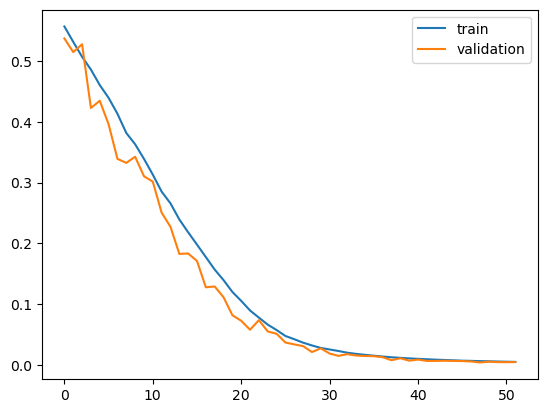

In [43]:
plt.plot(train_loss, label = "train")
plt.plot(val_loss, label = "validation")
plt.legend()
plt.show()

In [44]:
preds_ideation = []
with torch.no_grad():
  for i in range(X.shape[0]):
    x = torch.stack([torch.tensor(X.iloc[a]) for a in [i]])
    y_pred = model(x.to(device = device, dtype=torch.float))
    preds_ideation.append(torch.squeeze(y_pred).detach().numpy())

In [45]:
preds_ideation = np.array(preds_ideation)
preds_ideation

array([0.00348177, 0.00215469, 0.00402733, ..., 0.00348177, 0.00348177,
       0.00124272], dtype=float32)

In [46]:
errors = y - preds_ideation
errors

0      -0.003482
1      -0.002155
2      -0.004027
3      -0.005475
4       0.011075
          ...   
1256   -0.013440
1257    0.008204
1258   -0.003482
1259   -0.003482
1260   -0.001243
Name: ideation, Length: 1261, dtype: float64

In [47]:
errors.to_csv('errors_pred_ideation.csv', index=False)

In [48]:
error_train_ideation = pd.read_csv('result/errors_pred_ideation.csv')
error_train_suicatt = pd.read_csv('result/errors_pred_suicatt.csv')

In [49]:
suicide_db = pd.read_csv('data/final.csv')

y = suicide_db['suicatt']
X = suicide_db[suicide_db.columns[[1,2,3,4,5,7,8,9,10,11,14,15,17,30,31]]]

In [50]:
def normalize(x):
  return (x - 13) / (17 - 13)

X['age'] = X['age'].apply(normalize)

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\2353473130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['age'] = X['age'].apply(normalize)


In [51]:
# Train df
V = X.copy()
V['error_ideation'] = error_train_ideation
V['error_suicatt'] = error_train_suicatt
V[['ideation', 'suicatt']] = suicide_db[['ideation','suicatt']]



In [52]:
df_encoder_train = V.copy()
df_outs_train = df_encoder_train[['ideation', 'suicatt']]
df_features_train = df_encoder_train.drop(['error_suicatt', 'error_ideation','suicatt', 'ideation'], axis = 1)



df_encoder_test = V.copy()
df_outs_test = df_encoder_test[['ideation', 'suicatt']]
df_features_test = df_encoder_test.drop(['error_suicatt', 'error_ideation','suicatt', 'ideation'], axis = 1)

In [53]:
encoding_dim = 1
number_of_features = len(df_encoder_train.columns)


In [54]:
import numpy as np # linear algebra
from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from tensorflow.python.client import device_lib
import keras
from keras import optimizers
from keras.layers import LeakyReLU

In [55]:
# ICoNet

keras.backend.clear_session()
input_dim = Input(shape = (number_of_features, ))
input_dim2 = Input(shape = (number_of_features -4  , ))

# Encoder Layers
encoded1 = Dense(40, activation = 'relu')(input_dim)
encoded2 = Dense(20, activation = 'relu')(encoded1)
encoded5 = Dense(5, activation = 'relu')(encoded2)
encoded13 = Dense(encoding_dim, activation = 'linear')(encoded5)

merged = keras.layers.concatenate([encoded13, input_dim2], axis=-1)

# Decoder Layers
decoded1 = Dense(100, activation = 'relu')(merged)
decoded2 = Dense(500, activation = 'relu')(decoded1)
decoded3 = Dense(500, activation = 'relu')(decoded2)
decoded4 = Dense(250, activation = 'relu')(decoded3)
decoded5 = Dense(50, activation = 'relu')(decoded4)


decoded13 = Dense(2, activation = 'sigmoid')(decoded4)

# Combine Encoder and Deocder layers
counter = Model(inputs = [input_dim, input_dim2], outputs = [decoded13])


optimizer = keras.optimizers.Nadam(learning_rate= 0.0001)
# Compile the Model
counter.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [56]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1000,
                              verbose=0, mode='auto',
                                  restore_best_weights=True)


callbacks = [es]

print(df_encoder_train.shape, df_features_train.shape)
history = counter.fit(x = [df_encoder_train, df_features_train], y = df_outs_train, epochs = 500, 
                batch_size = 128, shuffle = True,
                validation_data=([df_encoder_test,df_features_test],df_outs_test),
               #callbacks = callbacks
                
               )

(1261, 18) (1261, 14)
Epoch 1/500
10/10 [==============================] - 4s 105ms/step - loss: 0.4752 - val_loss: 0.3280
Epoch 2/500
10/10 [==============================] - 0s 20ms/step - loss: 0.2422 - val_loss: 0.1559
Epoch 3/500
10/10 [==============================] - 0s 18ms/step - loss: 0.1457 - val_loss: 0.1269
Epoch 4/500
10/10 [==============================] - 0s 16ms/step - loss: 0.1195 - val_loss: 0.1062
Epoch 5/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0957 - val_loss: 0.0722
Epoch 6/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0561 - val_loss: 0.0321
Epoch 7/500
10/10 [==============================] - 0s 17ms/step - loss: 0.0208 - val_loss: 0.0104
Epoch 8/500
10/10 [==============================] - 0s 17ms/step - loss: 0.0088 - val_loss: 0.0029
Epoch 9/500
10/10 [==============================] - 0s 16ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 10/500
10/10 [==============================] - 0s 16ms/step - loss: 8.

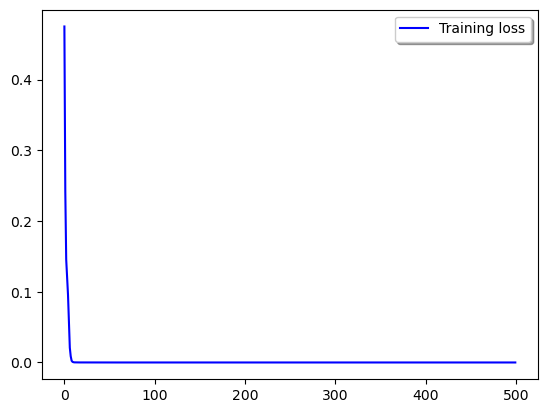

In [57]:
#Vamos ver como foi o treino?
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], color='b', label="Training loss")
legend = plt.legend(loc='best', shadow=True)

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

In [59]:
counter = Model(inputs = [input_dim,input_dim2], outputs = encoded13)
encoded_input = Input(shape = (encoding_dim, ))
unit_values = pd.DataFrame(counter.predict([df_encoder_test,df_features_test]))
unit_values

25/40 [=================>............] - ETA: 0s

40/40 [==============================] - 0s 2ms/step


,0
0,0.704557
1,0.887139
2,0.852727
3,0.658540
4,0.067480
...,...
1256,0.425988
1257,0.446658
1258,0.704557
1259,0.704557


In [60]:
counter = Model(inputs = [input_dim,input_dim2], outputs = decoded13)
encoded_input = Input(shape = (encoding_dim, ))

encoded_test = pd.DataFrame(counter.predict([df_encoder_test,df_features_test]))
encoded_test = encoded_test.add_prefix('feature_')



40/40 [==============================] - 0s 3ms/step


In [61]:
mean_absolute_error(encoded_test['feature_0'], df_outs_test['suicatt']), mean_absolute_error(encoded_test['feature_1'], df_outs_test['ideation'])

(0.07295796166967242, 0.07295796446925355)

In [62]:
mean_squared_error(encoded_test['feature_0'], df_outs_test['suicatt']), mean_squared_error(encoded_test['feature_1'], df_outs_test['ideation'])

(0.07295793866853509, 0.07295794101718302)

In [63]:
r2_score(encoded_test['feature_0'], df_outs_test['suicatt']), r2_score(encoded_test['feature_1'], df_outs_test['ideation'])

(0.28735190173260416, -0.7799257908992445)

In [64]:
import pandas as pd
import numpy as np
import math
from operator import itemgetter

In [65]:
mutaveis = ['yswdcat', 'yssccat', 'ysadcat', 'ysapcat', 'ysdbcat', 'ysabcat', 'planning', 'cesdcat', 'enbprobs_yes', 'hlthprobs_yes']
columns = ['ysincat', 'ysexcat', 'yswdcat', 'yssccat', 'ysadcat', 'ysapcat', 'ysdbcat', 'ysabcat',  'planning', 'cesdcat', 'enbprobs_yes', 'hlthprobs_yes', 'female', 'age']

In [66]:
def get_fitness(t):
    return t[1]

In [67]:
class Operations:
  def __init__(self, rng):
    self.rng = rng

  def create_pop(self, n):
    #cada indivíduo deve ter uma len = quantidade de atributos mutáveis em X
    pop = self.rng.integers(0, 1, (n, len(mutaveis)), endpoint=True)
    #lista com n indivíduos, cada um sendo uma lista de 0 ou 1 com len = len(mutaveis)
    return pop

  def uni_crossover(self, ind1, ind2):
    #len(ind1) = len(ind2)

    ind1 = np.array(ind1)
    ind2 = np.array(ind2)
    ind_temp = ind1.copy()
    op = self.rng.choice([False, True], len(ind1))

    for iterator, value in enumerate(op):
        if value:

            ind1[iterator]=ind2[iterator]
            ind2[iterator]=ind_temp[iterator]

    return ind1, ind2

  def uni_mutation(self, ind):
    ind = self.rng.choice([0,1], size=len(mutaveis), replace=True)
    return ind

  def operator(self, n, parents, prob_c, prob_m):
    p = 0
    new_pop = []
    while p < n - 2:
        op = self.rng.choice(['c', 'm'], 1, True, [prob_c, prob_m])
        if op == 'c':
            ind1, ind2 = self.uni_crossover(parents[p], parents[p+1])
            new_pop.append(ind1)
            new_pop.append(ind2)
            p += 2
        else:
            ind = self.uni_mutation(parents[p])
            new_pop.append(ind)
            p += 1

    if len(new_pop) == n - 3:
        ind1, ind2 = self.uni_crossover(parents[-3], parents[-2])
        new_pop.append(ind1)
        new_pop.append(ind2)
    elif len(new_pop) == n - 2:
        ind = self.uni_mutation(parents[-2])
        new_pop.append(ind)

    new_pop.append(parents[-1])

    return new_pop

  def result(self, X, y, e, Xcf, model):
    V = X.copy()
    V[['suicatt', 'ideation']] = y
    V[['error_suicatt', 'error_ideation']] = e
    predX = model.predict([V,X])
    predXcf = model.predict([V,Xcf])

    return predX - predXcf

  def fitness(self, pop, X, y, e, model, mut):
    fit = []
    for i in pop:
        rmse = 0
        aux_metrics = []
        Xcf = X.copy()
        for idx in range(len(mut)):
          if i[idx] == 1:
            Xcf[mut[idx]] = (~Xcf[mut[idx]].astype(bool)).astype(int)

        diff = self.result(X, y, e, Xcf, model)
        N = diff.shape[0]
        eval = 0
        for aux in range(N):
          diff1 = diff[aux][0] ** 2
          diff2 = diff[aux][1] ** 2
          eval += (diff1 + diff2)
        rmse = math.sqrt(eval / N)

        fit.append(rmse * (1/sum(i)))

    return fit

  def sort_pop(self, pop, fit):
    sorted_pop = []
    for i in range(len(pop)):
        sorted_pop.append((pop[i], fit[i]))
    sorted_pop.sort(key = get_fitness)
    return sorted_pop

  def tournament(self, k, n, sorted_pop):
    parents = []
    for i in range(n-1):
        aux = self.rng.choice(list(range(len(sorted_pop))), k, False)
        aux_p = []
        for j in aux:
          aux_p.append(sorted_pop[j])
        aux_p.sort(key = get_fitness)
        parents.append(aux_p[-1][0])
    parents.append(sorted_pop[-1][0])
    return parents

In [68]:
def run(rng, tam_pop, qtd_ger, prob_c, prob_m, X, y, e, model, k = 2):
    best_hist = []
    best_ind = -1

    op = Operations(rng)
    pop = op.create_pop(tam_pop)
    fit = op.fitness(pop, X, y, e, model, mutaveis)

    for i in range(qtd_ger):
        sorted_pop = op.sort_pop(pop, fit)
        parents = op.tournament(k, tam_pop, sorted_pop)
        pop = op.operator(tam_pop, parents, prob_c, prob_m)
        fit = op.fitness(pop, X, y, e, model, mutaveis)

        index, _ = max(enumerate(fit), key=itemgetter(1))
        best_hist.append((pop[index], fit[index]))
        if best_ind == -1 or best_ind[1] < fit[index]:
            best_ind = (pop[index], fit[index])

    return best_ind, best_hist

In [69]:
X = V.drop(columns=['suicatt', 'ideation', 'error_suicatt', 'error_ideation'])
y = V[['suicatt', 'ideation']]
e = V[['error_suicatt', 'error_ideation']]
model = Model(inputs = [input_dim,input_dim2], outputs = decoded13)

rng = np.random.default_rng(883)
best_ind, best_hist = run(rng = rng, tam_pop = 100, qtd_ger = 50, prob_c = 0.6, prob_m = 0.4, X = X, y = y, e = e, model = model)
print(best_hist)
print('-'*70)
print(best_ind)

16/40 [===========>..................] - ETA: 0s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 1s 12ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 10ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 8ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 9ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 8ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 10ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 8ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 8ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 9ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 8ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 8ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 1s 11ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 9ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 0s 7ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 2s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 1s 13ms/step


C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 6/40 [===>..........................] - ETA: 0s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 6/40 [===>..........................] - ETA: 0s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 5/40 [==>...........................] - ETA: 0s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 5/40 [==>...........................] - ETA: 0s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 5/40 [==>...........................] - ETA: 0s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 5/40 [==>...........................] - ETA: 0s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


 1/40 [..............................] - ETA: 1s

C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: divide by zero encountered in scalar divide
  fit.append(rmse * (1/sum(i)))
C:\Users\PLour\AppData\Local\Temp\ipykernel_25480\621217718.py:86: RuntimeWarning: invalid value encountered in scalar multiply
  fit.append(rmse * (1/sum(i)))


40/40 [==============================] - 1s 16ms/step
[(array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int64), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), 0.8619704239070332), (array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]), 0.8619704239070332), (array([0, 0, 0, 0, 0,